# Analysis of the Mental Health in the Tech Industry

# Introduction

The aim of this work is to analyze the [Mental Health in the Tech Industry](https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry) and check the validity of it.

This data is form Open Source Mental Illness (OSMI) using survey data from years 2014, 2016, 2017, 2018 and 2019. Each survey measures and attitudes towards mental health and frequency of mental health problems.

The raw data already was processed using Python, SQL and Excel for cleaning and manipulation.

Steps involved in cleaning were:

<ul>
    <li>Similar questions were group together</li>
    <li>Values for answers were made consistent (ie 1 == 1.0)</li>
    <li>Fixing spelling errors</li>
</ul>

# Data Description

The SQLite database contains of 3 tables: 

<b>Survey</b> (PRIMARY KEY INT SurveyID, TEXT Description)

<b>Question</b> (PRIMARY KEY QuestionID, TEXT QuestionText)

<b>Answer</b> (PRIMARY/FOREIGN KEY SurveyID, PRIMARY KEY UserID, PRIMARY/FOREIGN KEY QuestionID, TEXT AnswerText)

Survey table links to Answer table with SurveyID.
Question table links to Answer table with QuestionID.

# Notebook preparation

We need to import libraries for visualization, Exploratory Data Analysis (EDA) and set parameters for displaying charts.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3

from collections import Counter
from wordcloud import WordCloud

# Setting up styles for plotting
custom_palette = sns.color_palette("Blues_r")
sns.set_palette(custom_palette)

# Activating white grid
sns.set(style="whitegrid")

# Default figure size
sns.set(rc={"figure.figsize": (10, 6)})

# Display the full text without truncation
pd.set_option("display.max_colwidth", None)

Now we can establish connection to SQLite database. We need to create a new database and open a database connection to allow sqlite3 to work with it.

In [2]:
# Set up SQL database path
con = sqlite3.connect("data/mental_health.sqlite")

The returned connection object <b>con</b> represents the connection to the on-disk database. With <b>cor.execute()</b> command we can run SQL queries and get results. For fetching results from SQL queries we will need to use a database cursor.

In [3]:
def sql_query(query):
    """
    Return dataframe of sql query
    
    :param query: SQL Query code
    :return: Dataframe also show Row and Column number
    """
    cur = con.cursor()
    cur.execute(query)
    column_name = [c[0] for c in cur.description]
    df = pd.DataFrame(cur.fetchall(), columns=column_name)
    cur.close() # Close connection
    
    print(f"Rows:{df.shape[0]} Columns:{df.shape[1]}")
    return df

# Data Cleaning

As we already know that data was cleaned before, we can also check if tables link to each other and return valid information.

In [4]:
# Table 1: Survey
df_survey = sql_query('''SELECT * FROM Survey''')
df_survey

Rows:5 Columns:2


,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


From Survey table we can see 5 rows and 3 columns: Description and SurveyID (Primary Key) which consists of different years of surveys.

In [5]:
# Table 2: Question
df_question = sql_query('''SELECT * FROM Question''')

df_question.tail()

Rows:105 Columns:2


,questiontext,questionid
100,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,114
101,"If yes, what condition(s) have you been diagnosed with?",115
102,"If maybe, what condition(s) do you believe you have?",116
103,Which of the following best describes your work position?,117
104,Do you work remotely?,118


The Question table have 105 rows and 2 columns: <b>questiontext</b> which is a question from survey and <b>questionid</b> which is unique id for that question.

From dataframe we can see that <b>questionid</b> starts from 1 and ends at 118 while we have only 105 rows. So we need to ask additional questions about this table:

<ul>
    <li>Do we have any duplicate questions?</li>
    <li>Why we have less questions than questionids?</li>
</ul>


In [6]:
# Check for duplicates in Question table questiontext feature

df = sql_query('''
SELECT DISTINCT questiontext 
FROM Question
''')

Rows:105 Columns:1


We get 105 rows, so we know there are no duplicate questions. Now let's check why we have less questions than ids.

In [7]:
df = sql_query('''
WITH cte AS (
    SELECT questionid, 
    LAG(questionid, 1) OVER (
        ORDER BY questionid
        ) AS question_after
    FROM 
        Question
)
SELECT questionid AS questionid, 
       question_after AS questionid_behind,
       (questionid - question_after) AS questionid_diff
FROM cte
WHERE questionid_diff > 1
''')
df

Rows:1 Columns:3


,questionid,questionid_behind,questionid_diff
0,48,34,14


From query, we can see that there are some missing questionid from 34 till 48, so we don't have 13 (35-47) questionsid.

In [8]:
df_answer = sql_query('''
SELECT * 
FROM Answer
''')

Rows:236898 Columns:4


In [9]:
df_answer.tail()

,AnswerText,SurveyID,UserID,QuestionID
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117
236897,Other,2016,2693,117


Answer table have 236 898 rows and 4 columns: 
<b>AnswerText</b> - Answer to the question from Question table.
<b>SurveyID</b> - Year of survey, links to SurveyID from Survey table.
<b>UserID</b> - Uniq ID number for user.
<b>QuestionID</b> - Uniq ID number for question, links to questionid from Question table.

We have 2 links between tables, so we can check if all values are valid between tables.
<ul>
<li>Validate if Survey PRIMARY KEY SurveyID links with Answer FOREIGN KEY SurveyID</li>
<li>Validate if Question PRIMARY KEY QuestionID links with Answer FOREIGN KEY QuestionID</li>
</ul>

In [10]:
df = sql_query('''
SELECT *
FROM Answer AS s
LEFT JOIN Survey AS a
ON s.SurveyID = a.SurveyID

''')

Rows:236898 Columns:6


After joining Answer and Survey we get same number of rows, so the joining was successful. Now proceed with Question and Answer tables.

In [11]:
df = sql_query('''
SELECT *
FROM Answer AS q
LEFT JOIN Question AS a
ON q.QuestionID = a.QuestionID

''')

Rows:236898 Columns:6


After joining tables we can see same number of rows, we can proceed further.

We can check how many answers types we have in our dataset.

In [12]:
df_questions = sql_query('''
SELECT COUNT(DISTINCT AnswerText) AS num_of_asnwer
FROM Answer
GROUP BY QuestionID
ORDER BY num_of_asnwer DESC
''')
df_questions.describe().transpose()

Rows:105 Columns:1


,count,mean,std,min,25%,50%,75%,max
num_of_asnwer,105.0,45.457143,132.829418,1.0,3.0,5.0,8.0,1020.0


# Exploratory data analysis

<b>Our top goal of analysis is to check people Mental Health in the Tech Industry.</b>
To get answer we need to check what kind of people are having survey, check theirs age, gender, check if they have some mental health problems, etc. But at the start let's check how open was the questions.

In [13]:
# Query to get number of possible variants to answers question.
df_questions = sql_query('''
SELECT COUNT(DISTINCT AnswerText) AS num_of_asnwer
FROM Answer
GROUP BY QuestionID
ORDER BY num_of_asnwer DESC
''')
df_questions.describe().transpose()

Rows:105 Columns:1


,count,mean,std,min,25%,50%,75%,max
num_of_asnwer,105.0,45.457143,132.829418,1.0,3.0,5.0,8.0,1020.0


Answers summary
<ul>
    <li>Most of questions are base by variants, 75% percent of questions consist 8 or less variants to answer the question.</li>
    <li>There are some open question where participants can enter their own answer.</li>
    <li>There are question where is possible to enter only one answer, like age.</li>
</ul>

## Which questions occurs on all years?

In [14]:
# Query to check if question occurs on individual year
df_all_questions = sql_query('''
WITH cte AS (
    SELECT
        QuestionID,
        MAX(CASE WHEN SurveyID = '2014' THEN 1 ELSE NULL END) AS "2014",
        MAX(CASE WHEN SurveyID = '2016' THEN 1 ELSE NULL END) AS "2016",
        MAX(CASE WHEN SurveyID = '2017' THEN 1 ELSE NULL END) AS "2017",
        MAX(CASE WHEN SurveyID = '2018' THEN 1 ELSE NULL END) AS "2018",
        MAX(CASE WHEN SurveyID = '2019' THEN 1 ELSE NULL END) AS "2019"
        FROM Answer
        GROUP BY QuestionID
)
SELECT *
FROM cte
WHERE "2014" = 1
    AND "2016" = 1
    AND "2017" = 1
    AND "2018" = 1
    AND "2019" = 1
''')

Rows:12 Columns:6


In [15]:
# Base by df_all_questions, 
# let's filter only those question which occurred on each year.
filtered_q = df_all_questions["QuestionID"].to_list()
filtered_q_str = ', '.join(map(str, filtered_q))

# Get question which occurs on all years
df_filtered_questions = sql_query(f'''
SELECT questiontext
FROM Question
WHERE questionID IN ({filtered_q_str})
''')

# Show questions
df_filtered_questions.head(len(filtered_q))

Rows:12 Columns:1


,questiontext
0,What is your age?
1,What is your gender?
2,What country do you live in?
3,"If you live in the United States, which state or territory do you live in?"
4,Are you self-employed?
5,Do you have a family history of mental illness?
6,Have you ever sought treatment for a mental health disorder from a mental health professional?
7,How many employees does your company or organization have?
8,Is your employer primarily a tech company/organization?
9,Does your employer provide mental health benefits as part of healthcare coverage?


### Questions summary
<ul>
    <li>There are 12 questions which included in all years.</li>
</ul>

## <b>How many participants work in Tech Insutry? </b>

First let's find out how many participants had the survey.

In [16]:
df_all_participants = sql_query('''
SELECT DISTINCT UserID
FROM Answer
''')

Rows:4218 Columns:1


<li>We have 4218 participants in survey.</li>

We need to check which question from database check people where they work. We can do it by searching by keyword <b>Tech</b>.

In [17]:
# Filter questions to get only "tech" related ones
df_temp = sql_query('''
SELECT *
FROM Question
WHERE questiontext LIKE '%tech%'
''')

df_temp

Rows:5 Columns:2


,questiontext,questionid
0,Is your employer primarily a tech company/organization?,9
1,Is your primary role within your company related to tech/IT?,13
2,Was your employer primarily a tech company/organization?,68
3,"Overall, how well do you think the tech industry supports employees with mental health issues?",85
4,Would you be willing to talk to one of us more extensively about your experiences with mental health issues in the tech industry? (Note that all interview responses would be used _anonymously_ and only with your permission.),88


<b>We can see we got 5 questions, but only 2 are interesting:</b>
<ul>
    <li>Is your employer primarily a tech company/organization?</li>
    <li>Was your employer primarily a tech company/organization?</li>
</ul>

Base by answers to these questions we filter our participants to those who work or use to work in Tech and those which are not.

In [18]:
# Filter data to get uniq users who work in Tech industry, 
# we assume 1 as a YES 
# while 0 and -1 as NO or Skipped

df_work_in_tech = sql_query('''
WITH cte AS (
    SELECT AnswerText, UserID
    FROM Answer
    WHERE QuestionID = 9 OR QuestionID = 68
)
SELECT DISTINCT UserID
FROM cte
WHERE AnswerText = 1
''')

Rows:3177 Columns:1


<li>3177 people working or use to work in Tech industry.</li>

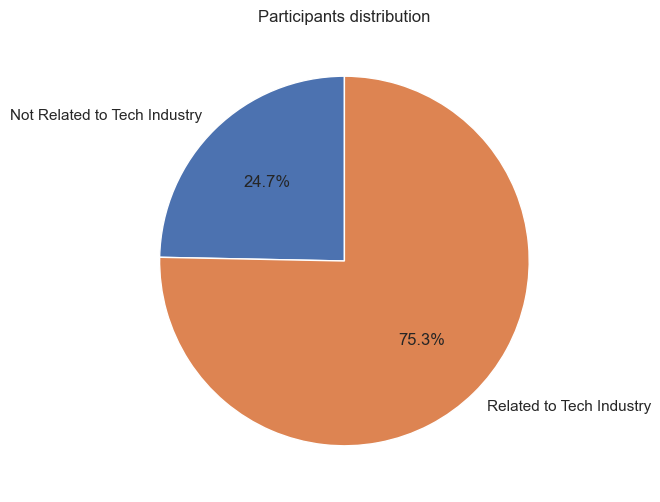

In [19]:
# Set up pie chart labels
pie_labels = ["Not related to Tech", "Working - Worked in Tech"]

# Set up data for pie plot
pie_data = {"Not Related to Tech Industry": df_all_participants.shape[0] - df_work_in_tech.shape[0], 
               "Related to Tech Industry": df_work_in_tech.shape[0]}

# Pie plot distribution
plt.pie(pie_data.values(), 
        labels=pie_data.keys(), 
        autopct='%1.1f%%', 
        startangle=90)

# Set title
plt.title("Participants distribution");

### Participants summary

<ul>
    <li>There are 4218 participants</li>
    <li>24.7% - 1041 is not related to Tech Industry</li>
    <li>75.3% - 3077 participant work in Tech Industry</li>
</ul>

We see that 75.3% of all 4218 participant work in Tech Industry, it's quite large portion of our data. Now we can work separately with them.

## <b>How old are participants?</b>

Let's draw boxplot for numeric age values which will help to identify any outliers.

In [20]:
# Question 1 - What is your age?
df_age = sql_query(f'''
SELECT AnswerText
FROM Answer
WHERE QuestionID = 1 
    AND UserID IN (
        WITH cte AS (
            SELECT AnswerText, UserID
            FROM Answer
            WHERE QuestionID = 9 OR QuestionID = 68
            )
        SELECT DISTINCT UserID
        FROM cte
        WHERE AnswerText = 1)
ORDER BY AnswerText DESC
''')

Rows:3177 Columns:1


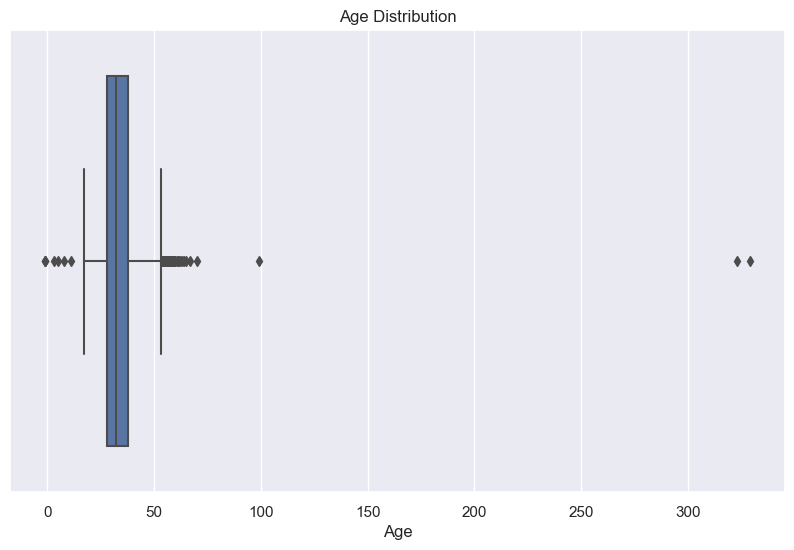

In [21]:
# Change values type
df_age["AnswerText"] = [int(x) for x in df_age["AnswerText"]]

# Plot box plot
sns.boxplot(data=df_age, 
            x="AnswerText")

# Set up title and labels
plt.title("Age Distribution")
plt.xlabel("Age");

In [22]:
# Show statistical view of data
df_age.describe().transpose().rename({"AnswerText":"With Outliers"})

,count,mean,std,min,25%,50%,75%,max
With Outliers,3177.0,33.525968,10.799263,-1.0,28.0,32.0,38.0,329.0


As we see in age there are some outliers, people have negative age and also there are people who are older than 300 years as chart shows. Let's check our data without outliers.

<b>We can assume people make a mistake while typing answers, but as we see further with answers, dataset have a lot of "-1" as an answer, we can assume it was an option to skip that question.</b>

Indentify outliers for <b>Age</b>.

In [23]:
# Extract lower and upper percentiles
q1, q3 = np.percentile(df_age["AnswerText"], [25, 75])

# Calculate the interquartile range 
iqr = q3 - q1

# Get outliers 
all_outliers_df_age = (df_age["AnswerText"] > q3 + iqr * 1.5) | (df_age["AnswerText"] < q1 - iqr * 1.5)

# Get all extreme outliers
extreme_outliers_df_age = (df_age["AnswerText"] > q3 + iqr * 3) | (df_age["AnswerText"] < q1 -iqr * 3)
f"All outliers: {all_outliers_df_age.sum()}, Extreme outliers: {extreme_outliers_df_age.sum()}"

'All outliers: 73, Extreme outliers: 4'

Now as we have outliers stored in variables we can plot boxplot again and check age distribution without outliers.

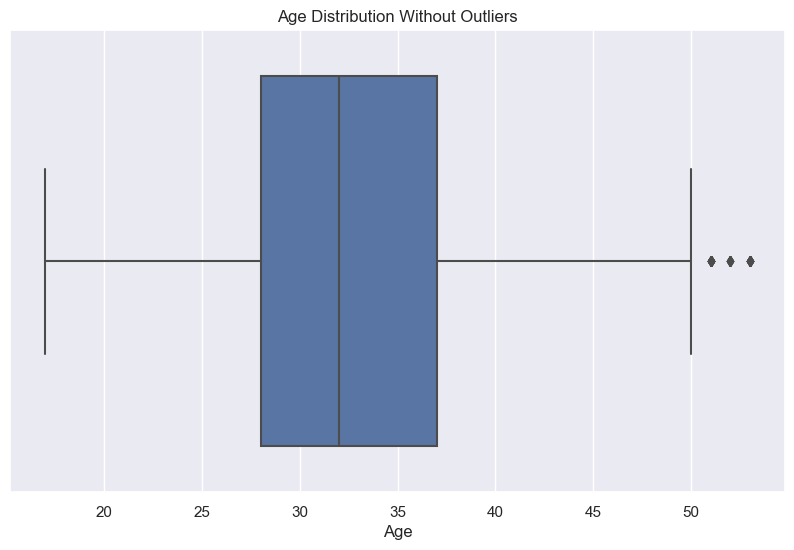

In [24]:
# Data without outliers
df_age_without_outliers = df_age[~all_outliers_df_age]

# Plot box plot
fig = sns.boxplot(data=df_age_without_outliers, 
                  x="AnswerText")

# Set up title and labels
plt.title("Age Distribution Without Outliers")
plt.xlabel("Age");

In [25]:
# Show statistical view of data without outliers
df_age_without_outliers.describe().transpose().rename({"AnswerText":"With Outliers"})

,count,mean,std,min,25%,50%,75%,max
With Outliers,3104.0,32.893363,6.945618,17.0,28.0,32.0,37.0,53.0


After removing outliers we get new ones, but they appeared because data was modified. Mean of our data increase from 33.5 to 33.9, standart deviation decrease from 10.8 to 6.9, min value now is 17 while max 53. 

Let's group age, to look which age groups participate in surveys more often. Outliers help us indentify age slices, as we know most people often start working from 16 and go to pension at about 60-70 we can set threshold from 16 to 70, but survey could include participants who are older and use to work, so let's make it till 120 people who not in this gap will be marked as skipped the question.

In [26]:
# Question 1 - What is your age?
df_age_group = sql_query('''
SELECT SurveyID AS Year,
    CASE
        WHEN CAST(AnswerText AS INT) BETWEEN 16 AND 29 THEN '16-29'
        WHEN CAST(AnswerText AS INT) BETWEEN 30 AND 39 THEN '30-39'
        WHEN CAST(AnswerText AS INT) BETWEEN 40 AND 49 THEN '40-49'
        WHEN CAST(AnswerText AS INT) BETWEEN 50 AND 59 THEN '50-59'
        WHEN CAST(AnswerText AS INT) BETWEEN 60 AND 69 THEN '60-69'
        WHEN CAST(AnswerText AS INT) BETWEEN 70 AND 120 THEN '70 and older'
        WHEN CAST(AnswerText AS INT) < 16 OR CAST(AnswerText AS INT) > 121 THEN 'Skipped'
    END AS age_group,
    COUNT() AS group_count
FROM Answer
WHERE QuestionID = 1 
    AND UserID IN (WITH cte AS (
        SELECT AnswerText, UserID
        FROM Answer
        WHERE QuestionID = 9 OR QuestionID = 68
        )
        SELECT DISTINCT UserID
        FROM cte
        WHERE AnswerText = 1)
GROUP BY SurveyID, age_group
ORDER BY SurveyID, age_group
''')

Rows:29 Columns:3


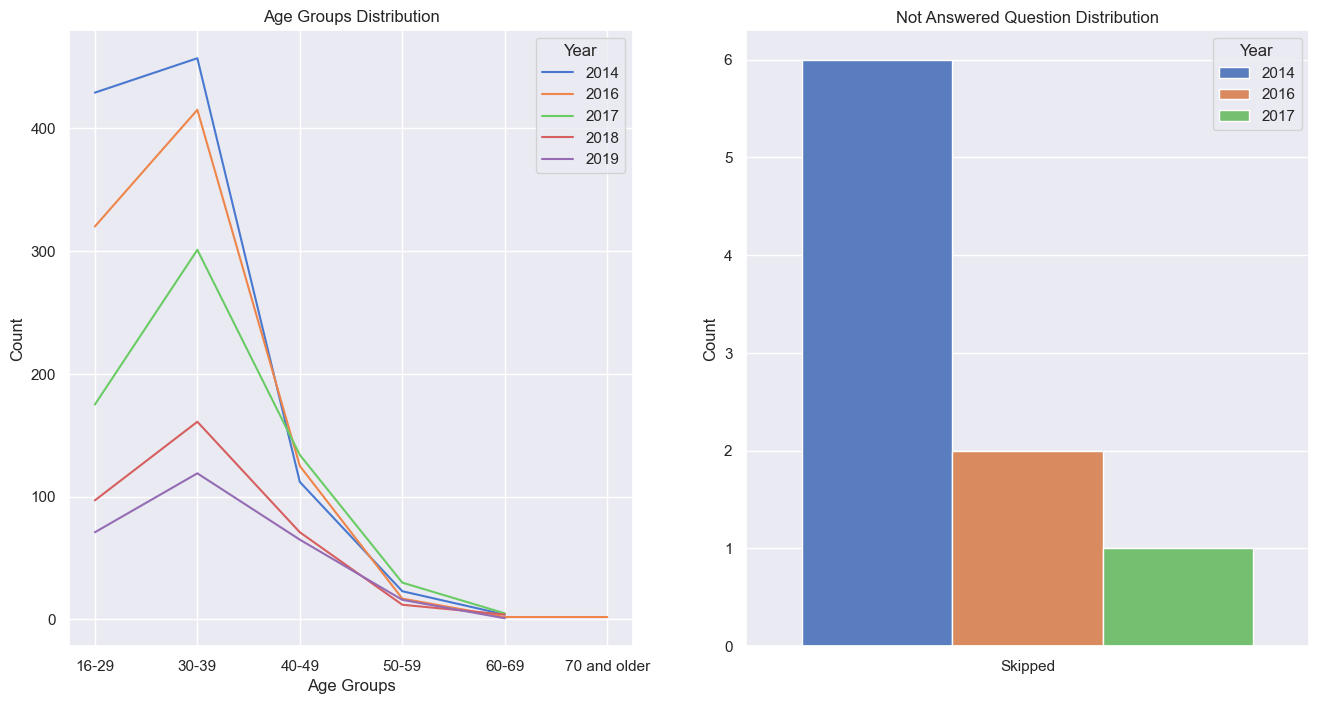

In [27]:
# Create a custom pastel color palette
sum_of_colors = df_age_group["Year"].nunique()
custom_pastel_palette = sns.color_palette("muted", n_colors=sum_of_colors)

# Filter out values
df_filtered = df_age_group[df_age_group["age_group"] != "Skipped"]
df_not_answered = df_age_group[df_age_group["age_group"] == "Skipped"]

# Create horizontally stacked plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

# Plot subplot 1 linechart
sns.lineplot(data=df_filtered, 
             x="age_group", 
             y="group_count", 
             hue="Year", 
             palette=custom_pastel_palette, 
             ax=ax1)

# Plot subplot 2 bar plot
sns.barplot(data=df_not_answered, 
            x="age_group", 
            y="group_count", 
            hue="Year", 
            palette=custom_pastel_palette[:len(df_not_answered)], 
            ax=ax2)

# Set up title, labels and legend
ax1.set_title("Age Groups Distribution")
ax1.set_xlabel("Age Groups")
ax1.set_ylabel("Count")

ax2.set_title("Not Answered Question Distribution")
ax2.set_xlabel("")
ax2.set_ylabel("Count")

# Customize legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, title="Year")

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, title="Year");

#### Age summary

<ul>
    <li>We found outliers based by IQR * 1.5 and IQR * 3: Age have 73 outliers, while 4 of them are extreme.</li>
    <li>Most of people are in first 3 groups.</li>
    <li>Biggest age group is 30-39.</li>
    <li>There are participants in 2016 survey who are older than 70.</li>
    <li>In 2014, 2016 and 2017 year surveys there was participants who skipped the question or input was with a mistake.</li>
</ul>

### What are the genders of participants?

To get the answer first we need to get all unique answers from survey, check which of them repeats and group them.

In [28]:
# Question 2 - What is your gender?
df_gender = sql_query('''
SELECT AnswerText, COUNT() AS num_of_genders
FROM Answer
WHERE QuestionID = 2 
    AND UserID IN (WITH cte AS (
        SELECT AnswerText, UserID
        FROM Answer
        WHERE QuestionID = 9 OR QuestionID = 68
        )
        SELECT DISTINCT UserID
        FROM cte
        WHERE AnswerText = 1)
GROUP BY AnswerText
ORDER BY num_of_genders DESC
''')

Rows:85 Columns:2


In [29]:
df_gender

,AnswerText,num_of_genders
0,Male,2135
1,Female,654
2,male,175
3,female,91
4,-1,19
...,...,...
80,All,1
81,Agender/genderfluid,1
82,Agender trans woman,1
83,A little about you,1


As we see most people are <b>Male or Female</b>, we can also see people who skipped the question, as there are a lot of different answers we will group them as <b>Others</b>.

In [30]:
# Group genders
df_gender_grouped = sql_query('''
SELECT 
    SurveyID,
    CASE
        WHEN LOWER(AnswerText) = 'male' THEN 'Male'
        WHEN LOWER(AnswerText) = 'female' THEN 'Female'
        WHEN AnswerText = '-1' THEN 'Skipped'
        ELSE 'Others'
        END AS gender,
    COUNT() AS gender_group_count
FROM Answer
WHERE QuestionID = 2
    AND UserID IN (WITH cte AS (
        SELECT AnswerText, UserID
        FROM Answer
        WHERE QuestionID = 9 OR QuestionID = 68
        )
        SELECT DISTINCT UserID
        FROM cte
        WHERE AnswerText = 1)
GROUP BY gender
ORDER BY gender_group_count DESC
''')

Rows:4 Columns:3


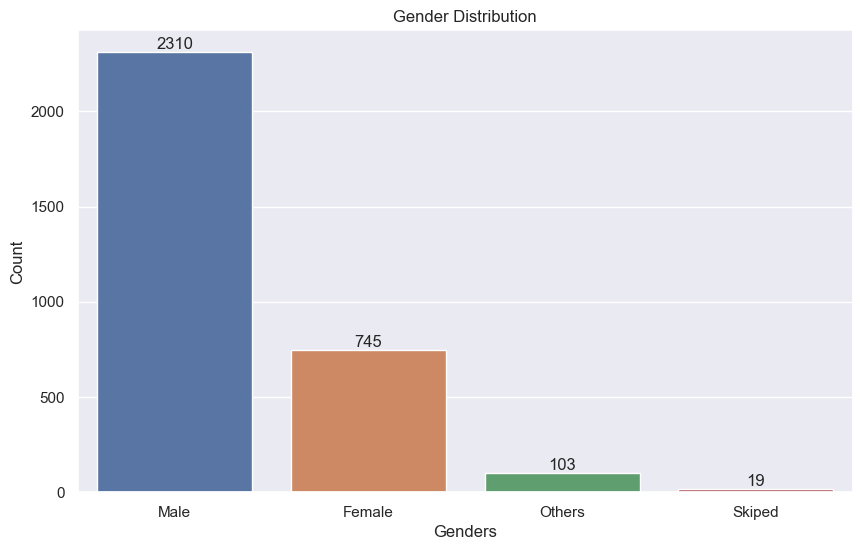

In [31]:
# Plot barplot
ax = sns.barplot(data=df_gender_grouped, 
                 x='gender', 
                 y='gender_group_count')

# Add values on bars
ax.bar_label(ax.containers[0])

# Set up title, labels
plt.title("Gender Distribution")
plt.xlabel("Genders")
plt.ylabel("Count");

### Genders summary

<ul>
    <li>Most of participants was Male, taking more than half of survey with 2310 participants.</li>
    <li>Female have 745 participants</li>
    <li>19 people didin't want to answer the question.</li>
    <li>There are genders like Nonbinary, Transgender, etc. but we add them  to Others which takes 103 people, they number quite low and it will be easier to analyze data.</li>
</ul>

## What mental health/ilness questions occured in every surveys?

First we need to find questions which have similarity to health or mental and also filter to look only to those questions which included in all dataset.

In [32]:
# Which questions asking about health or mental 
# and are in all dataset
df_health_filtered = sql_query(f'''
SELECT *
FROM Question
WHERE (questiontext LIKE '%mental%' 
    OR questiontext LIKE '%health%')
    AND questionid IN ({filtered_q_str})
''')

df_health_filtered

Rows:5 Columns:2


,questiontext,questionid
0,Do you have a family history of mental illness?,6
1,Have you ever sought treatment for a mental health disorder from a mental health professional?,7
2,Does your employer provide mental health benefits as part of healthcare coverage?,10
3,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,11
4,Would you bring up a mental health issue with a potential employer in an interview?,12


<ul>
    <li>We got 5 questions which are answered in all dataset through all years. </li>
</ul>

## Does participant family have any health/illness problem history?

In [33]:
# Question 6 - Do you have a family history of mental illness?
df_family_history = sql_query('''
SELECT 
    AnswerText AS 'Answer', 
    SurveyID AS Year, 
    COUNT(*) AS num_of_rows,
    SUM(COUNT(*)) OVER (PARTITION BY SurveyID) AS sum_of_rows,
    ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER (PARTITION BY SurveyID), 2) as percent
FROM Answer
WHERE QuestionID = 6 
    AND UserID IN (
        WITH cte AS (
            SELECT AnswerText, UserID
            FROM Answer
            WHERE QuestionID = 9 OR QuestionID = 68
        )
        SELECT DISTINCT UserID
        FROM cte
        WHERE AnswerText = 1
    )
GROUP BY SurveyID, AnswerText
''')

Rows:14 Columns:5


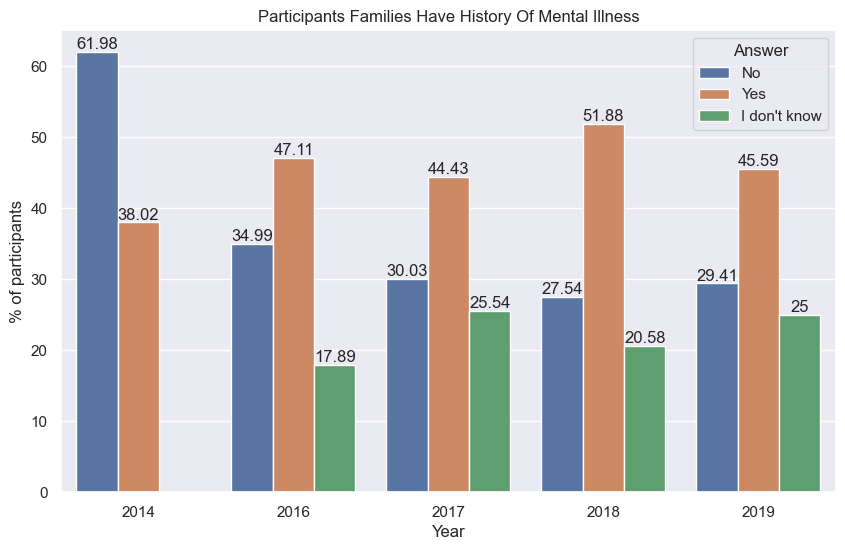

In [34]:
# Bar plot
ax = sns.barplot(data=df_family_history, 
                 x="Year", 
                 y="percent", 
                 hue="Answer")

# Add values on top of bars
for i in ax.containers:
    ax.bar_label(i,)

# Set up title and label
plt.title("Participants Families Have History Of Mental Illness")
plt.xlabel("Year")
plt.ylabel("% of participants");

### Participant family mental health/illness summary.

<ul>
    <li>In 2014 nobody answer 'I don't know', possible in this year there was only Yes or No answer types.</li>
    <li>We see that only in 2014 there was less families with Mental Illness.</li>
    <li>In all other years participants families have Mental Ilness.</li>
    <li>In 2018 number of people who answer No and I don't know is smaler than people who answer Yes.</li>
    <li>We already see that participants families have Mental Illness which could be indicator that participants could inherit it.</li>
</ul>

## How many people sought treatment for mental health?

In [35]:
# Question 7 - Have you ever sought treatment
# for a mental health disorder from a mental health professional?
df_sought_treatment = sql_query('''
SELECT 
    AnswerText, 
    SurveyID , 
    COUNT() num_of_rows,
    ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER (PARTITION BY SurveyID), 2) as percent,
    CASE
        WHEN AnswerText = '1' THEN 'Yes'
        ELSE 'No'
    END AS 'Answer'
FROM Answer
WHERE QuestionID = 7 
    AND UserID IN (WITH cte AS (
        SELECT AnswerText, UserID
        FROM Answer
        WHERE QuestionID = 9 OR QuestionID = 68
        )
        SELECT DISTINCT UserID
        FROM cte
        WHERE AnswerText = 1)
GROUP BY SurveyID, AnswerText
''')
df_sought_treatment

Rows:10 Columns:5


,AnswerText,SurveyID,num_of_rows,percent,Answer
0,0,2014,517,50.15,No
1,1,2014,514,49.85,Yes
2,0,2016,377,42.70,No
3,1,2016,506,57.30,Yes
4,0,2017,262,40.56,No
5,1,2017,384,59.44,Yes
6,0,2018,122,35.36,No
7,1,2018,223,64.64,Yes
8,0,2019,98,36.03,No
9,1,2019,174,63.97,Yes


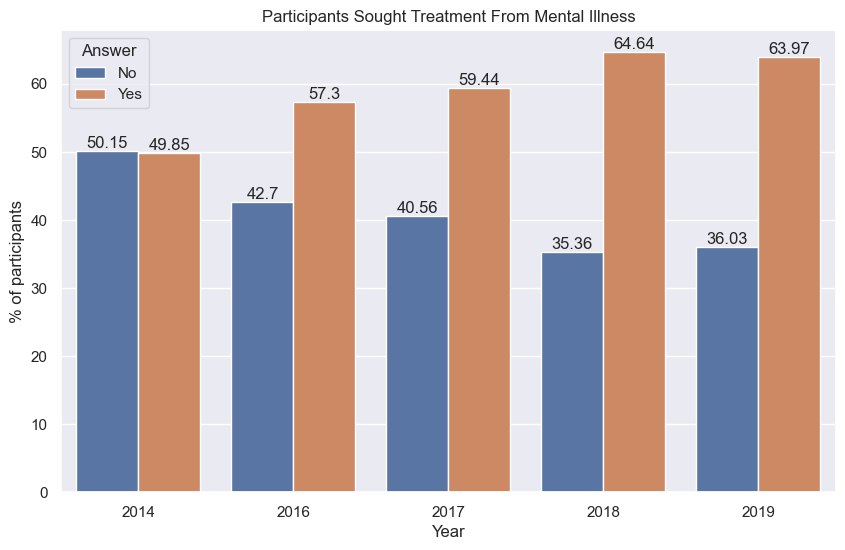

In [36]:
# Bar plot
ax = sns.barplot(data=df_sought_treatment, 
                 x="SurveyID", 
                 y="percent", 
                 hue="Answer")

# Add values on bars
for container in ax.containers:
    ax.bar_label(container)    

# Set up title, label and legend
plt.title("Participants Sought Treatment From Mental Illness")
plt.xlabel("Year")
plt.ylabel("% of participants");

### Participants sought treatment summary

<ul>
    <li>In 2014 we see that participants divide almost to equal sides of seeking treatment.</li>
    <li>2016 and 2017 years show, that people who sought treatment starting to increase.</li>
    <li>2018 year show that seeking treatment difference is almost double.</li>
    <li>2019 year is simmilar to 2018, while still being very high, with less than 1% difference.</li>
</ul>

## Does mental health problems in family history have any impact on participants?

To get answer we will select participants which family have any health problems and thant check only those participants if they tried sought treatment for them self.

In [37]:
# Combine two questions, check if family have any health problems if so 
# check if participant sought for any help
df_impact_on_people = sql_query('''
SELECT 
    AnswerText, 
    SurveyID , 
    COUNT() num_of_rows,
    ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER (PARTITION BY SurveyID), 2) as percent,
    CASE
        WHEN AnswerText = '1' THEN 'Yes'
        ELSE 'No'
    END AS 'Answer'
FROM Answer
WHERE QuestionID = 7 
    AND UserID IN (
        SELECT UserID
        FROM Answer
        WHERE QuestionID = 6 
            AND AnswerText = 'Yes' 
            AND UserID IN (
                WITH cte AS (
                    SELECT AnswerText, UserID
                    FROM Answer
                    WHERE QuestionID = 9 OR QuestionID = 68
                    )
                SELECT DISTINCT UserID
                FROM cte
                WHERE AnswerText = 1
                )
        )
GROUP BY SurveyID, AnswerText
''')

Rows:10 Columns:5


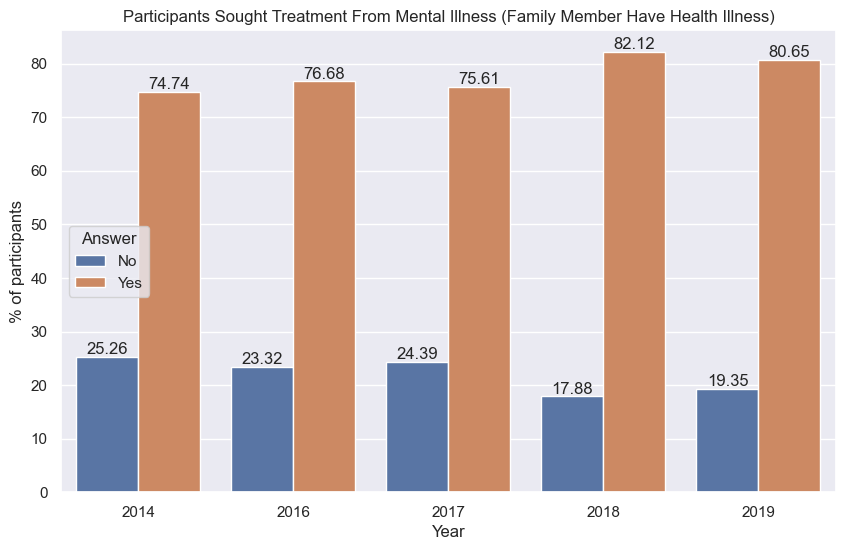

In [38]:
# Does mental health problems in family history have any impact on participants.

# Bar plot
ax = sns.barplot(data=df_impact_on_people, 
                 x="SurveyID", 
                 y="percent", 
                 hue="Answer")

# Add values on bars
for container in ax.containers:
    ax.bar_label(container)
    

# Set up title, label and legend
plt.title("Participants Sought Treatment From Mental Illness (Family Member Have Health Illness)")
plt.xlabel("Year")
plt.ylabel("% of participants");
sns.move_legend(ax, "center left")

### Perticipants whos family seek help summary 

<ul>
    <li>We see that over all years people whose family had mental illness problems tend to have them too.</li>
    <li>Over years people tend to sought treatment more often.</li>
</ul>

## How participants answer to open questions?

To get know more about participants let's filter our data by answers, to look how they answering. First let's get the threshold on answer variants to know which questions we should analyze.

In [39]:
# Get number of unique answers for each question
df_open_questions = sql_query('''
SELECT 
    Q.QuestionID, 
    Q.questiontext, 
    COUNT(DISTINCT A.AnswerText) AS num_of_asnwer
FROM Answer A
JOIN Question Q
    ON A.QuestionID = Q.questionid
WHERE UserID IN (
        WITH cte AS (
            SELECT AnswerText, UserID
            FROM Answer
            WHERE QuestionID = 9 OR QuestionID = 68
        )
        SELECT DISTINCT UserID
        FROM cte
        WHERE AnswerText = 1
    )
GROUP BY A.QuestionID
ORDER BY num_of_asnwer DESC
''')
df_open_questions.head(15)

Rows:105 Columns:3


,questionid,questiontext,num_of_asnwer
0,86,Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.,843
1,61,Describe the conversation with coworkers you had about your mental health including their reactions.,393
2,63,Describe the conversation your coworker had with you about their mental health (please do not use names).,388
3,59,"Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.",314
4,82,Describe the circumstances of the badly handled or unsupportive response.,273
5,73,Describe the conversation you had with your previous coworkers about your mental health including their reactions.,262
6,87,"If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.",238
7,75,Describe the conversation your coworker had with you about their mental health (please do not use names)..1,229
8,71,"Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.",208
9,103,Any additional notes or comments,131


We see gap between 131 and 208 answers, it is good indicator which question should be use. Question having less than 100 answers are not open, we can see that most of question who have a lot of answers are describe questions, so it will be good line to split our data and set threshold to 100 and use keyword <b>Describe</b>. 

In [40]:
# Filtering dataset
df_open_questions_filtered = sql_query('''
SELECT 
    Q.QuestionID, 
    Q.questiontext, 
    COUNT(DISTINCT A.AnswerText) AS num_of_asnwer
FROM Answer A
JOIN Question Q
    ON A.QuestionID = Q.questionid
WHERE 
    Q.questiontext LIKE '%Describe%' 
GROUP BY A.QuestionID
HAVING num_of_asnwer > 100
ORDER BY num_of_asnwer DESC
''')

Rows:8 Columns:3


In [41]:
# Puting QuestionID to the list
open_q_id = df_open_questions_filtered["questionid"].tolist()
open_q_id = ', '.join(map(str, open_q_id))

In [42]:
# Get answer from each question 
df_answers_filtered = sql_query(f'''
SELECT AnswerText 
FROM Answer
WHERE 
    QuestionID IN ({open_q_id}) AND 
    AnswerText != "-1" AND 
    UserID IN (
        WITH cte AS (
            SELECT AnswerText, UserID
            FROM Answer
            WHERE QuestionID = 9 OR QuestionID = 68
        )
        SELECT DISTINCT UserID
        FROM cte
        WHERE AnswerText = 1
    )
''')

Rows:2929 Columns:1


In [43]:
# List for words
word_counts = {}

# Count words in sentences
for answer in df_answers_filtered["AnswerText"]:
    words = answer.lower().split(" ")
    for word in words:
        if len(word) > 4: # Looking for long words, discarding function words (and, so, it, for, etc..)
            word = word.strip(",.")
            word_counts[word] = word_counts.get(word, 0) + 1

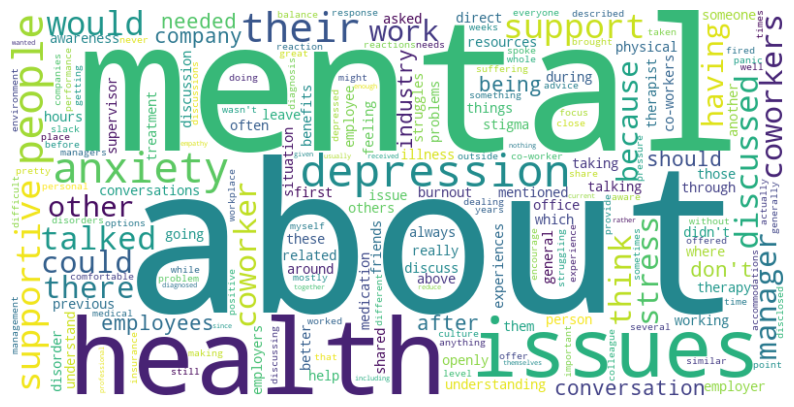

In [44]:
# Plot word cloud
wordcloud = WordCloud(width=800, 
                      height=400, 
                      background_color='white'
                     ).generate_from_frequencies(word_counts)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

### Answers summary
<ul>
    <li>We take only 8 relative open questions from our database.</li>
    <li>We get 2929 answers from participants.</li>
    <li>From word cloud we can already see some negative health illness: depression, anxiety, stress, issues.</li>
    <li>We can also see positive ways how to fix the problem: conversations, support, supportive, therapy. </li>
</ul>

# Summary

<ul>
    <li>75% of the questions have variants as an answer, there are also some questions where participants can answer freely,  share their experience, also there are question limited to one answer - age.</li>
    
<li>We get the list of questions which occurred in every survey. There are 12 of them.</li>
    
<li>There are 4218 participant in survey, but only 3177 related to tech industry.</li>
    
<li>Base by age there was 73 outliers, 4 of them are extreme ones. Most of people are distributes from 16 to 49 years old. There are some cases where participants are older or younger. Some people skipped the question.</li>
    
<li>Large size of participants takes Males and Females, there are some Other genders and people who also didin't want to answer and skipped the question.</li>
    
<li>We found 5 questions which occurred in each survey.</li>
    
<li>Found that only in 2014 there was more people who says that theirs family don't have any history of mental illness. While in other years people tend to answer Yes. In 2018 survey here was more people who answer yes than No or I don't know.</li>
    
<li>In 2014 divide almost to equal sizes for sought treatment from mental illness. From 2016 number of participants who sought help start increasing. In 2018 and 2019 distribution is very similar, with high number of seeking help.</li>
    
<li>Participants whose family member have health illness tend to have it to.</li>
    
<li>From open questions we can see that people tend to talk about mental health problems. Most of the times depression, anxiety, stress and other issues appears. People try to solve problems, they mention conversations, support, therapy, discussion.</li>
</ul>

# Suggestion how to improve analysis.

<li>As we see there are more than 100 questions, we can improve our analysis by checking other questions and answers.</li>
    
<li>Getting more data in other years, now data distributes not equally.</li>
    
<li>Checking answers base by position in job.</li>